In [1]:
from IPython.display import Image

# CNTK 103: Part C -Многоуровневый перцептрон с MNIST

Мы предполагаем, что вы успешно завершили CNTK 103 Part A.

В этом уроке мы изучим многослойный персептрон по данным MNIST. Этот ноутбук использует API Python. Если вы ищете этот пример в BrainScript, посмотрите [здесь](https://github.com/Microsoft/CNTK/tree/release/2.2/Examples/Image/GettingStarted)

## Introduction

**Проблема** 
Как и в CNTK 103B, мы продолжим работу над той же проблемой распознавания цифр в данных MNIST. Данные MNIST содержат рукописные цифры с небольшим фоновым шумом.

In [2]:
# Рисунок 1
Image(url= "http://3.bp.blogspot.com/_UpN7DfJA0j4/TJtUBWPk0SI/AAAAAAAAABY/oWPMtmqJn3k/s1600/mnist_originals.png", width=200, height=200)

**Цель**:
Наша цель - подготовить классификатор, который будет идентифицировать цифры в наборе данных MNIST. Кроме того, мы стремимся добиться более низкой частоты ошибок с многослойным персептроном по сравнению с логистической регрессией Multi-class. 

**Подход**:
Используются те же 5 этапов, которые мы использовали в предыдущем учебнике: чтение данных, предварительная обработка данных, создание модели, изучение параметров модели и оценка (a.k.a. testing/prediction) модели. 
- Чтение данных: мы будем использовать CNTK Text reader 
- Предварительная обработка данных: включена в часть A (предлагаемый раздел расширения). 

Это похоже с CNTK 102. В учебнике мы адаптируем ту же модель для работы с данными MNIST с 10 классами вместо 2 классов, которые мы использовали в CNTK 102.


In [3]:
from __future__ import print_function # Используйте определение функции из версии (скажем 3.x from 2.7 interpreter)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (требуется только для нашей системы сборки)
C.cntk_py.set_fixed_random_seed(1) # перемешаем, чтобы примеры не повторялись

%matplotlib inline

## Чтение данных

В этом разделе мы будем читать данные, сгенерированные в CNTK 103 Part A

In [4]:
# Определение размеров данных
input_dim = 784
num_output_classes = 10

В этом уроке мы используем данные MNIST, которые вы загрузили, используя ноутбук CNTK_103A_MNIST_DataLoader notebook. Набор данных содержит 60 000 обучающих изображений и 10 000 тестовых изображений, каждое изображение которых составляет 28 х 28 пикселей. Таким образом, количество функций равно 784 (= 28 x 28 пикселей), 1 на пиксель. Переменная `num_output_classes` установлена в 10, соответствующая количеству цифр (0-9) в наборе данных.

Данные находятся в следующем формате:

    |labels 0 0 0 0 0 0 0 1 0 0 |features 0 0 0 0 ... 
                                                  (784 integers each representing a pixel)
    
В этом уроке мы будем использовать пиксели изображения, соответствующие целочисленному потоку с именем  "features". Мы определяем функцию  `create_reader` для чтения данных обучения и тестирования с помощью [CTF deserializer](https://cntk.ai/pythondocs/cntk.io.html?highlight=ctfdeserializer#cntk.io.CTFDeserializer). Метки [1-hot encoded](https://en.wikipedia.org/wiki/One-hot). Посмотрите учебник CNTK 103A для визуализации формата данных.


In [5]:
# Прочтите текст в формате CTF (как упоминалось выше), используя десериализатор CTF из файла
def create_reader(path, is_training, input_dim, num_label_classes):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        labels = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
        features   = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [6]:
# Убедитесь, что данные обучения и тестирования созданы и доступны для этого учебника.
# Мы выполняем поиск в двух местах в наборе инструментов для кэшированного набора данных MNIST.
data_found = False
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file = os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found = True
        break
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
print("Data directory is {0}".format(data_dir))

Data directory is data\MNIST


## Создание модели

Наш многослойный персептрон будет относительно простым с двумя скрытыми слоями (`num_hidden_layers`). Количество узлов в скрытом слое является параметром, заданным `hidden_layers_dim`.  На следующем рисунке показана вся модель, которую мы будем использовать в этом учебнике в контексте данных MNIST.

![](http://cntk.ai/jup/cntk103c_MNIST_MLP.png)

Если вы не знакомы с терминами *hidden layer* и *number of hidden layers*, изучите  учебник CNTK 102.

Каждый слой Dense (как показано ниже) показывает размеры ввода, размеры вывода и функцию активации, которые использует этот слой. В частности, ниже показан слой: размер входного сигнала = 784 (1 размер для каждого входного пикселя), размер вывода = 400 (количество скрытых узлов, параметр, заданный пользователем) и функция активации [relu](https://cntk.ai/pythondocs/cntk.ops.html?highlight=relu#cntk.ops.relu).

![](http://www.cntk.ai/jup/cntk103c_MNIST_dense.png)

В этой модели мы имеем 2 слоя, называемых скрытыми слоями, каждый из которых имеет функцию активации `relu`  и один выходной слой без активации.

Выходной размер (a.k.a. number of hidden nodes) во 2-м скрытом слое установлен на 400 и 200 как показано выше на иллюстрации. В приведенном ниже коде мы сохраняем оба слоя с одинаковым количеством скрытых узлов (установлено в 400). Количество скрытых слоев равно 2. Заполните следующие значения:
- num_hidden_layers
- hidden_layers_dim

Конечный выходной слой представляет вектор из 10 значений. Поскольку мы будем использовать softmax  для нормализации вывода модели, мы не используем функцию активации в этом слое. Операция softmax активируется с функцией [loss function](https://cntk.ai/pythondocs/cntk.losses.html)  которую мы будем использовать позже в этом уроке.

In [7]:
num_hidden_layers = 2
hidden_layers_dim = 400

Сетевой вход и выход: 
- **input** переменная (ключевая концепция CNTK): 
>Переменная **input** - это контейнер, в котором мы заполняем различные наблюдения в этом случае пикселями изображения во время обучения модели (a.k.a.training)и оценки модели (a.k.a. testing). Таким образом, форма  `input` должна соответствовать форме данных, которые будут предоставлены. Например, когда данные представляют собой изображения с высотой 10 пикселей и шириной 5 пикселей, размер функции ввода будет равен 50 (что соответствует общему числу пикселей изображения). Подробнее о данных и их размерах можно найти в отдельных учебниках.


**Вопрос** Каков размер ввода выбранной вами модели? Это имеет фундаментальное значение для нашего понимания переменных в представлении сети или модели в CNTK.


In [8]:
input = C.input_variable(input_dim)
label = C.input_variable(num_output_classes)

## Многослойная настройка Перцептрона

Нижеследующая ячейка представляет собой прямой перевод иллюстрации приведенной выше модели.

In [9]:
def create_model(features):
    with C.layers.default_options(init = C.layers.glorot_uniform(), activation = C.ops.relu):
            h = features
            for _ in range(num_hidden_layers):
                h = C.layers.Dense(hidden_layers_dim)(h)
            r = C.layers.Dense(num_output_classes, activation = None)(h)
            return r
        
z = create_model(input)

`z` будет использоваться для представления вывода сети.

Мы вводили сигмоидную функцию в CNTK 102, в этом уроке вы должны попробовать различные функции активации в скрытом слое. Вы можете сделать это сразу и посмотреть результат в учебнике или запустить предустановленный учебник, а затем попробовать другую функцию.


** Задание **
- Запишите ошибку обучения, которую вы получаете с помощью `sigmoid` в качестве функции активации
- Теперь переключитесь на `relu` в качестве функции активации и посмотрите, можете ли вы улучшить свою обучающую ошибку - training error

*Вопрос*: Назовите некоторые из поддерживаемых функций активации. Какая функция активации дает наименьшую ошибку обучения?

In [10]:
# Масштабируйте вход в диапазон 0-1, разделив каждый пиксель на 255.
z = create_model(input/255.0)

### Параметры модели обучения

Как и в предыдущем учебнике, мы используем функцию `softmax` для сопоставления накопленных доказательств или активации с распределением вероятности по классам (подробности функции [softmax function](http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.softmax)).

## Обучение

Подобно CNTK 102, мы минимизируем кросс-энтропию -"cross-entropy" между меткой -"label" и прогнозируемой вероятностью -"predicted probability" сетью. Если эта терминология звучит незнакомо, изучите CNTK 102 для переподготовки. 

In [11]:
loss = C.cross_entropy_with_softmax(z, label)

### Оценка

Чтобы оценить классификацию, можно сравнить выход сети, который для каждого наблюдения излучает вектор доказательств (может быть преобразован в вероятности с использованием функций `softmax` ) с размерностью, равной числу классов.

In [12]:
label_error = C.classification_error(z, label)

### Настройка обучения

Тренер -"trainer" стремится уменьшить функцию  `loss` различными подходами к оптимизации, [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (`sgd`), являющийся базовой. Как правило, можно начинать со случайной инициализации параметров модели. Оптимизатор `sgd` вычислял бы `loss` или ошибку между прогнозируемой меткой против соответствующей метки истины и используя  [gradient-decent](http://www.statisticsviews.com/details/feature/5722691/Getting-to-the-Bottom-of-Regression-with-Gradient-Descent.html) генерирует новые параметры модели набора в одной итерации. 

Вышеупомянутое обновление параметров модели с использованием одного наблюдения за раз привлекательно, поскольку для загрузки в память не требуется весь набор данных (all observation)  а также требуется вычисление градиента за меньшее количество данных, что позволяет проводить обучение на больших наборах данных. Тем не менее, обновления, созданные с использованием одного образца наблюдения за раз, могут сильно различаться между итерациями. Промежуточное основание - загрузить небольшой набор наблюдений и использовать среднее значение `loss` или ошибку из этого набора для обновления параметров модели. Это подмножество называется *minibatch*.

С помощью мини-отсеков -"minibatches" мы часто выбираем наблюдение из более крупного набора учебных материалов. Мы повторяем процесс обновления параметров модели с использованием различной комбинации учебных образцов и в течение периода времени минимизируем `loss` (и ошибку). Когда инкрементные частоты ошибок больше не изменяются значительно или после заданного количества максимальных минимумов для тренировки, мы утверждаем, что наша модель обучена.

Один из ключевых параметров для оптимизации [optimization](https://en.wikipedia.org/wiki/Category:Convex_optimization) называется  `learning_rate`. На данный момент мы можем рассматривать его как фактор масштабирования, который модулирует, насколько мы меняем параметры на любой итерации. Мы рассмотрим более подробные сведения в следующем учебном пособии.
Мы готовы создать нашего тренера -"trainer". 

In [13]:
# Создайте экземпляр объекта тренера для обучения модели
learning_rate = 0.2
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, label_error), [learner])

Сначала создадим некоторые вспомогательные функции, которые понадобятся для визуализации различных функций, связанных с обучением.

In [14]:
# Определите функцию полезности для вычисления скользящей средней суммы.
# Более эффективная реализация возможна с помощью функции np.cumsum()
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Нужно отправить копию массива
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Определяет утилиту, которая печатает ход обучения
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

### Запуск тренера

Теперь мы готовы обучать нашу полностью связанную нейронную сеть. Мы хотим решить, какие данные нам нужны для обучения в учебном движке.

В этом примере каждая итерация оптимизатора будет работать с образцами размером `minibatch_size` .  Мы хотели бы тренироваться во всех 60000 наблюдениях. Кроме того, мы сделаем несколько проходов через данные, заданные переменной `num_sweeps_to_train_with`.  С помощью этих параметров мы можем продолжить обучение нашей простой многослойной сети персептрона.

In [15]:
# Инициализация параметров для тренера
minibatch_size = 64
num_samples_per_sweep = 60000
num_sweeps_to_train_with = 15
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

In [16]:
# Создайте reader  для набора данных обучения
reader_train = create_reader(train_file, True, input_dim, num_output_classes)

# Сопоставьте потоки данных со входом и метками.
input_map = {
    label  : reader_train.streams.labels,
    input  : reader_train.streams.features
} 

# Запуск тренера и обучение модели
training_progress_output_freq = 500

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    
    # Чтение mini batch из файла данных обучения
    data = reader_train.next_minibatch(minibatch_size, input_map = input_map)
    
    trainer.train_minibatch(data)
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 2.2945, Error: 92.19%
Minibatch: 500, Loss: 0.2529, Error: 10.94%
Minibatch: 1000, Loss: 0.0808, Error: 1.56%
Minibatch: 1500, Loss: 0.1367, Error: 4.69%
Minibatch: 2000, Loss: 0.0143, Error: 0.00%
Minibatch: 2500, Loss: 0.0140, Error: 0.00%
Minibatch: 3000, Loss: 0.0103, Error: 0.00%
Minibatch: 3500, Loss: 0.0410, Error: 3.12%
Minibatch: 4000, Loss: 0.0218, Error: 1.56%
Minibatch: 4500, Loss: 0.0203, Error: 1.56%
Minibatch: 5000, Loss: 0.0054, Error: 0.00%
Minibatch: 5500, Loss: 0.0026, Error: 0.00%
Minibatch: 6000, Loss: 0.0092, Error: 0.00%
Minibatch: 6500, Loss: 0.0199, Error: 0.00%
Minibatch: 7000, Loss: 0.0080, Error: 0.00%
Minibatch: 7500, Loss: 0.0213, Error: 0.00%
Minibatch: 8000, Loss: 0.0077, Error: 0.00%
Minibatch: 8500, Loss: 0.0027, Error: 0.00%
Minibatch: 9000, Loss: 0.0010, Error: 0.00%
Minibatch: 9500, Loss: 0.0027, Error: 0.00%
Minibatch: 10000, Loss: 0.0069, Error: 0.00%
Minibatch: 10500, Loss: 0.0047, Error: 0.00%
Minibatch: 11000, Loss: 0.0011, 

Построим ошибки над различными обучающими мини-фильтрами. Обратите внимание, что по мере того, как мы повторяем потери при тренировке, мы видим некоторые промежуточные изменения. 

Следовательно, мы используем более мелкие мини-отсеки, и использование `sgd` позволяет нам иметь большую масштабируемость при выполнении больших наборов данных. Существуют расширенные варианты оптимизатора, уникальные для CNTK, которые позволяют использовать вычислительную эффективность для наборов данных реального мира и будут представлены в расширенных обучающих программах. 

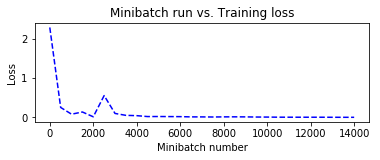

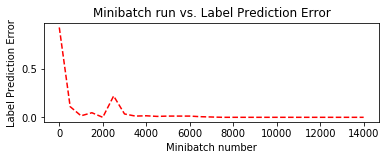

In [17]:
# Вычислить скользящую среднюю потерю, чтобы сгладить шум в SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Распечатаем потерю обучения и ошибку обучения
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

### Провести оценку / тестирование

Теперь, когда мы обучили сеть, давайте оценим подготовленную сеть по тестовым данным. Это делается с помощью `trainer.test_minibatch`.

In [18]:
# Чтение данных обучения
reader_test = create_reader(test_file, False, input_dim, num_output_classes)

test_input_map = {
    label  : reader_test.streams.labels,
    input  : reader_test.streams.features,
}

# Данные испытаний для обученной модели
test_minibatch_size = 512
num_samples = 10000
num_minibatches_to_test = num_samples // test_minibatch_size
test_result = 0.0

for i in range(num_minibatches_to_test):
    
    # Мы загружаем тестовые данные пакетами, указанными test_minibatch_size
    # Каждая точка данных в мини-отсеке представляет собой изображение цифры MNIST размером 784 
    # с одним пикселем на измерение, которое мы будем кодировать / декодировать 
    # с помощью обучаемой модели.
    data = reader_test.next_minibatch(test_minibatch_size,
                                      input_map = test_input_map)

    eval_error = trainer.test_minibatch(data)
    test_result = test_result + eval_error

# Среднее значение ошибки оценки всех тестовых мини-отсеков
print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

Average test error: 1.68%


Обратите внимание: эта ошибка очень сопоставима с нашей ошибкой обучения, указывающей на то, что наша модель имеет хорошую ошибку "out of sample" ошибка a.k.a. generalization error. Это означает, что наша модель может очень эффективно справляться с ранее невидимыми наблюдениями (во время учебного процесса). Это ключ, чтобы избежать явления переобучения.

**Важно** уменьшение ошибки по сравнению с многоклассовым LR (от CNTK 103B).

До сих пор мы имеем дело с совокупными мерами ошибки. Возьмем теперь вероятности, связанные с отдельными точками данных. Для каждого наблюдения функция `eval` возвращает распределение вероятности по всем классам. Классификатор обучается распознавать цифры, поэтому имеет 10 классов. Сначала проложим сетевой выход через функцию `softmax`. Это сопоставляет агрегированные активации по сети с вероятностями по 10 классам.

In [19]:
out = C.softmax(z)

Обратимся к небольшому minibatch из тестовых данных.

In [20]:
# Прочтите данные для оценки
reader_eval = create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
eval_input_map = {input: reader_eval.streams.features} 

data = reader_test.next_minibatch(eval_minibatch_size, input_map = test_input_map)

img_label = data[label].asarray()
img_data = data[input].asarray()
predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

In [21]:
# Найдите индекс с максимальным значением как для предсказанной, так и для основной истины
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

In [22]:
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [4, 5, 6, 7, 8, 9, 7, 4, 6, 1, 4, 0, 9, 9, 3, 7, 8, 4, 7, 5, 8, 5, 3, 2, 2]
Predicted: [4, 6, 6, 7, 8, 9, 7, 4, 6, 1, 4, 0, 9, 9, 3, 7, 8, 0, 7, 5, 8, 5, 3, 2, 2]


Давайте представим некоторые результаты

Image Label:  8


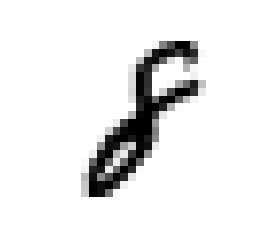

In [24]:
# Визуализируем случайное изображение
sample_number = 16
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)

**Задание**
-  Попробуйте изучить, как ведет себя классификатор с разными параметрами, например. изменение параметра `minibatch_size` от 25 до 64 или 128. Что происходит с частотой ошибок? Как ошибка сравнивается с логистическим классификатором регрессии?
- Попробуйте увеличить количество эпох
- Можете ли вы изменить сеть, чтобы снизить частоту ошибок обучения? Как изменяется *overfitting*?

**Ссылка на код**

Если вы хотите попробовать запустить руководство из командной строки Python, запустите [SimpleMNIST.py](https://github.com/Microsoft/CNTK/tree/release/2.2/Examples/Image/Classification/MLP/Python) пример.